<a href="https://colab.research.google.com/github/dongspam0209/medCAT_study/blob/main/MedCAT_Tutorial_%7C_Part_3_2_Extracting_Diseases_from_Electronic_Health_Records.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install medcat==0.3.3.1
# Get the scispacy model
! pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.2.4/en_core_sci_md-0.2.4.tar.gz

**Restart the runtime if on colab, sometimes necessary after installing models**

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

from medcat.cat import CAT
from medcat.cdb import CDB
from medcat.utils.vocab import Vocab

In [ ]:
DATA_DIR = "./data/"
vocab_path = DATA_DIR + "vocab.dat"
cdb_path = DATA_DIR + "cdb-medmen.dat"

In [ ]:
# Download the models and required data
!wget https://s3-eu-west-1.amazonaws.com/zkcl/vocab.dat -P ./data/
!wget https://s3-eu-west-1.amazonaws.com/zkcl/cdb-medmen.dat -P ./data/
!wget https://raw.githubusercontent.com/CogStack/MedCAT/master/tutorial/data/pt_notes.csv -P ./data/

--2020-03-29 14:33:17--  https://s3-eu-west-1.amazonaws.com/zkcl/vocab.dat
Resolving s3-eu-west-1.amazonaws.com (s3-eu-west-1.amazonaws.com)... 52.218.49.60
Connecting to s3-eu-west-1.amazonaws.com (s3-eu-west-1.amazonaws.com)|52.218.49.60|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 274445907 (262M) [application/x-www-form-urlencoded]
Saving to: ‘./data/vocab.dat’

vocab.dat           100%[===================>] 261.73M  31.4MB/s    in 9.1s    

2020-03-29 14:33:26 (28.9 MB/s) - ‘./data/vocab.dat’ saved [274445907/274445907]

--2020-03-29 14:33:27--  https://s3-eu-west-1.amazonaws.com/zkcl/cdb-medmen.dat
Resolving s3-eu-west-1.amazonaws.com (s3-eu-west-1.amazonaws.com)... 52.218.80.170
Connecting to s3-eu-west-1.amazonaws.com (s3-eu-west-1.amazonaws.com)|52.218.80.170|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 180335834 (172M) [application/x-www-form-urlencoded]
Saving to: ‘./data/cdb-medmen.dat’

cdb-medmen.dat      100%[====

## Loading models and preparing MedCAT

In [ ]:
# Create and load the CDB (Concept Database)
cdb = CDB()
cdb.load_dict(cdb_path)

# Create and load the Vocabulary
vocab = Vocab()
vocab.load_dict(vocab_path)

In [ ]:
# Create CAT - the main class from medcat used for concept annotation
cat = CAT(cdb=cdb, vocab=vocab)

# Set a couple of parameters, they are usually set via environments, but
#here we will do it explicitly. You can read more about each option in the
#medcat repository: https://github.com/CogStack/MedCAT
cat.spacy_cat.PREFER_FREQUENT = True
cat.spacy_cat.PREFER_ICD10 = False
cat.spacy_cat.WEIGHTED_AVG = True
cat.spacy_cat.MIN_CONCEPT_LENGTH = 3 # Ignore concepts (diseases) <= 3 characters
cat.spacy_cat.MIN_ACC = 0.2 # Confidence cut-off, everything bellow will not be displayed

## Testing NER+L

In [ ]:
text = "He was diagnosed with kidney failure"
doc = cat(text)
print(doc.ents)

(diagnosed, kidney failure)


In [ ]:
# If we want to see the CUI (ID) for each entity
for ent in doc.ents:
    print(ent, " - ", ent._.cui)

diagnosed  -  C0011900
kidney failure  -  C0035078


In [ ]:
# To show semantic types for each entity
for ent in doc.ents:
  print(ent, " - ", ent._.tui)

diagnosed  -  T033
kidney failure  -  T047


In [ ]:
# To show names for semenatic types
for ent in doc.ents:
  print(ent, " - ", cdb.tui2name[ent._.tui])

diagnosed  -  Finding
kidney failure  -  Disease or Syndrome


In [ ]:
# We can also show the entities in a nicer way using displacy form spaCy
from spacy import displacy
displacy.render(doc, style='ent', jupyter=True)

## Load the data

In [ ]:
# Load the dataset - the one we saved in the last step of Part 2.
#If using MIMIC-III this is a very big dataset, be careful with memory requirements.
data = pd.read_csv(DATA_DIR + "pt_notes.csv")

In [ ]:
# In this step we are only interested in the *text* column
data.head()

,Unnamed: 0_x,subject_id,chartdate,category,text,create_year,Unnamed: 0_y,gender,dob,dob_year,age_year
0,6,1,2079-01-01,General Medicine,"HISTORY OF PRESENT ILLNESS:, The patient is a ...",2079,1,F,2018-01-01,2018,61
1,7,1,2079-01-01,Rheumatology,"HISTORY OF PRESENT ILLNESS: , A 71-year-old fe...",2079,1,F,2018-01-01,2018,61
2,8,1,2079-01-01,Consult - History and Phy.,"HISTORY OF PRESENT ILLNESS:, The patient is a ...",2079,1,F,2018-01-01,2018,61
3,9,2,2037-01-01,Consult - History and Phy.,"CHIEF COMPLAINT:,1. Infection.,2. Pelvic pai...",2037,2,F,2018-01-01,2018,19
4,10,2,2037-01-01,Dermatology,"SUBJECTIVE:, This is a 29-year-old Vietnamese...",2037,2,F,2018-01-01,2018,19


## Run unsupervised training

In [ ]:
# The first step that we want to do when using MedCAT is unsupervised training, it is in detail
#explain in the paper: https://arxiv.org/abs/1912.10166
# To run it we first set CAT into the train mode
cat.train = True

# Print statistics on the CDB before training (note that if you are using the
#medmen cdb it will already have some training)
cat.cdb.print_stats()

# Run the annotation procedure over all the documents we have,
#given that we have a large number of documents this can take quite some time.
#~2 days, but you don't need to run it over everything 500K docs is enough
for i, text in enumerate(data['text'].values):
    # This will now run the training in the background
    _ = cat(text)

    # So we know how things are moving
    if i % 100 == 0:
        print("Finished {} - text blocks".format(i))

# Print statistics on the CDB after training
cat.cdb.print_stats()

# Disable the training mode
cat.train = False

Number of concepts: 34,632
Number of names:    96,529
Number of concepts that received training: 30,501
Number of seen training examples in total: 624,019
Average training examples per concept:     20.5
Finished 0 - text blocks
Finished 100 - text blocks
Finished 200 - text blocks
Finished 300 - text blocks
Finished 400 - text blocks
Finished 500 - text blocks
Finished 600 - text blocks
Finished 700 - text blocks
Finished 800 - text blocks
Finished 900 - text blocks
Finished 1000 - text blocks
Number of concepts: 34,632
Number of names:    96,529
Number of concepts that received training: 30,511
Number of seen training examples in total: 727,452
Average training examples per concept:     23.8


## Annotate Documents

We are not interested in all medical concepts that exist in UMLS, that is why we will filter by Semantic Type (TUI) to only:
1. T047 - Disease or Syndrom
2. T048 - Mental or Behavioral Dysfunction

It is possible to filter after the detection process, but always better to define the filter as part of MedCAT

A full list of semantic types in UMLS is available [here](https://metamap.nlm.nih.gov/Docs/SemanticTypes_2018AB.txt).

In [ ]:
# IMPORTANT: Set TUI filters
cat.spacy_cat.TUI_FILTER = ['T047', 'T048']

For each row in our dataframe `data` we want to get all diseases that appear in the `text` column. In UMLS a disease is defined by a CUI, so we want to have the following output after the annotation is done:
```
cui_location = {<CUI>: [<row_id>, <row_id>, ...], ...}
```

In [ ]:
# This will be a map from CUI to a list of documents where it appears: {"cui": [<doc_id>, <doc_id>, ...], ..}
cui_location = {}
# Let's also save the TUI location (semantic type)
tui_location = {}

### Use Multiprocessing

We can annotate documents one by one, using the `annotated_document = cat(text)` option, but it will work much faster if we do it using the `multi_processing` method from medcat.

When using multi_processing medcat requires the following format for input documents:
```
in_data = [(doc_id, doc_text), (doc_id, doc_text), ...]
```
The output is (return from medcat):
```
out_data = [(doc_id, {'entities': [...], 'text': <...>), (doc_id, {'entities': [...], 'text': <...>}), ...]
```

NOTE: If using the full UMLS CDB and a lot of processors (e.g. 32) it is very memory demanding (~ 32GB). The annotation process on 32 processors and 1M large text documents takes ~1h.

In [ ]:
# Let's test the multi processing function first
in_data = [(1, "He was a diabetic patient")]
results = cat.multi_processing(in_data, nproc=2)
print(results)

[(1, {'entities': [{'cui': 'C0011847', 'tui': 'T047', 'type': 'Disease or Syndrome', 'source_value': 'diabetic', 'acc': '0.4698911047970945', 'start': 9, 'end': 17, 'id': '0', 'pretty_name': 'diabetes', 'icd10': '', 'umls': '', 'snomed': ''}], 'text': 'He was a diabetic patient'})]


The returned list of `entities` contains the following:

`cui` - ID of the detected entity in the CDB (in our case UMLS)

`tui` - Semantic type ID

`type` - Semantic type

`source_value` - What exact source value was detected

`acc` - Confidence score for this detection

`start` - The start character for the entity in the original string

`end` - End character for the entity in the original string

`id` - Internal ID, each entity inside a document has an unique ID

`pretty_name` - The pretty name for this entity linked with the CUI

`icd10` - If we are using a medical CDB, we'll also get ICD10 codes

`umls` - If the CDB was something other than UMLS, we would get the potential link to UMLS.

`snomed` - If we ar eusing a medical CDB this would link to the equivalent SNOMED concept

In [ ]:
# If we have a use-case (like ours) where we do not care about anything else but the
#detected CUI (ID of the concept), we can do the following:
in_data = [(1, "He was a diabetic patient")]
results = cat.multi_processing(in_data, nproc=2, only_cui=True)
print(results)

[(1, {'entities': ['C0011847'], 'text': 'He was a diabetic patient'})]


In [ ]:
batch_size = 10000
batch = []
cnt = 0
for id, row in data.iterrows():
    text = row['text']
    # Skip text if under 10 characters, not really necessary as we have filtered before,
    #but I like to be sure.
    if len(text) > 10:
        batch.append((id, text))

    if len(batch) > batch_size or id == len(data) - 1:
        # Update the number of processors depending on your machine.
        #We are using the only_cui option, means the
        #returned entities will only have a CUI (no other information, try both
        #if interested).
        results = cat.multi_processing(batch, nproc=2, only_cui=True)

        for pair in results:
            row_id = pair[0]
            cui_list = set(pair[1]['entities']) # Convert to set to get unique CUIs

            for cui in cui_list:
                if cui in cui_location:
                    cui_location[cui].append(row_id)
                else:
                    cui_location[cui] = [row_id]

                # This is not necessary as it can be done later, we have
                #the cdb.cui2tui map. But whatever
                tui = cdb.cui2tui[cui]
                if tui in tui_location and row_id not in tui_location[tui]:
                    tui_location[tui].append(row_id)
                elif tui not in tui_location:
                    tui_location[tui] = [row_id]

        cnt += 1
        print("Done: {} - rows".format((cnt -1)*batch_size + len(batch)))

        # Reset the batch
        batch = []

Done: 1088 - rows


In this case we did not care about the full results from medcat, we only needed to know for each CUI (disease ID), where it appeared.

In [ ]:
# Check one of the returned results, just in case
results[0]

(100,
 {'entities': ['C0020538',
   'C0020538',
   'C0020538',
   'C0085207',
   'C0010054',
   'C0010054',
   'C0242510',
   'C0020538',
   'C0085207',
   'C0013537',
   'C0017601',
   'C0018799',
   'C0085612',
   'C0032285',
   'C0085606',
   'C0003864',
   'C0027765',
   'C0012634',
   'C0020538',
   'C0018799',
   'C0085207'],
  'text': 'REASON FOR CONSULTATION: , Management of blood pressure.,HISTORY OF PRESENT ILLNESS: , The patient is a 38-year-old female admitted following a delivery.  The patient had a cesarean section.  Following this, the patient was treated for her blood pressure.  She was sent home and she came back again apparently with uncontrolled blood pressure.  She is on multiple medications, unable to control the blood pressure.  From cardiac standpoint, the patient denies any symptoms of chest pain, or shortness of breath.  She complains of fatigue and tiredness.  The child had some congenital anomaly, was transferred to Hospital, where the child has had surgery. 

In [ ]:
# If we want to convert a CUI back to its name
cdb.cui2pretty_name['C0009324']

'ulcerative colitis'

In [ ]:
# Save the data so that we don't have to do the annotation again
import pickle
pickle.dump(cui_location, open(DATA_DIR + "cui_location.dat", 'wb'))
pickle.dump(tui_location, open(DATA_DIR + "tui_location.dat", 'wb'))

In [ ]:
# Load
import pickle
cui_location = pickle.load(open(DATA_DIR + "cui_location.dat", 'rb'))
tui_location = pickle.load(open(DATA_DIR + "tui_location.dat", 'rb'))

## Plot a couple of things
This is not necessary at this stage, but to be sure things are ok we will still do it

In [ ]:
# We are going to count the number of subjects (patietns) for each CUI
cui_subjects = {}
cui_subjects_unique = {}
for cui in cui_location:
    for location in cui_location[cui]:
        subject_id = data.iat[location, list(data.columns).index('subject_id')]
        if cui in cui_subjects:
            cui_subjects[cui].append(subject_id)
            cui_subjects_unique[cui].add(subject_id)
        else:
            cui_subjects[cui] = [subject_id]
            cui_subjects_unique[cui] = {subject_id}

In [ ]:
cui_nsubjects = [('cui', 'nsubjects')]
for cui in cui_subjects_unique.keys():
    cui_nsubjects.append((cui, len(cui_subjects_unique[cui])))
df_cui_nsubjects = pd.DataFrame(cui_nsubjects[1:], columns=cui_nsubjects[0])

Add a couple of columns that can be useful

In [ ]:
df_cui_nsubjects = df_cui_nsubjects.sort_values('nsubjects', ascending=False)
# Add TUI for each CUI
df_cui_nsubjects['tui'] = ['unk'] * len(df_cui_nsubjects)
cols = list(df_cui_nsubjects.columns)
for i in range(len(df_cui_nsubjects)):
    cui = df_cui_nsubjects.iat[i, cols.index('cui')]
    tui = cdb.cui2tui.get(cui, 'unk')
    df_cui_nsubjects.iat[i, cols.index('tui')] = tui

# Add name for each CUI
df_cui_nsubjects['name'] = ['unk'] * len(df_cui_nsubjects)
cols = list(df_cui_nsubjects.columns)
for i in range(len(df_cui_nsubjects)):
    cui = df_cui_nsubjects.iat[i, cols.index('cui')]
    name = cdb.cui2pretty_name.get(cui, 'unk')
    df_cui_nsubjects.iat[i, cols.index('name')] = name


# Add the percentage column
total_subjects = len(data['subject_id'].unique())
df_cui_nsubjects['perc_subjects'] = (df_cui_nsubjects['nsubjects'] / total_subjects) * 100

df_cui_nsubjects.head()

,cui,nsubjects,tui,name,perc_subjects
12,C0020538,117,T047,hypertension,64.285714
4,C0012634,66,T047,disease,36.263736
10,C0018799,59,T047,heart diseases,32.417582
1,C0010054,55,T047,Coronary Artery Disease,30.219780
6,C0242510,55,T048,drug use,30.219780


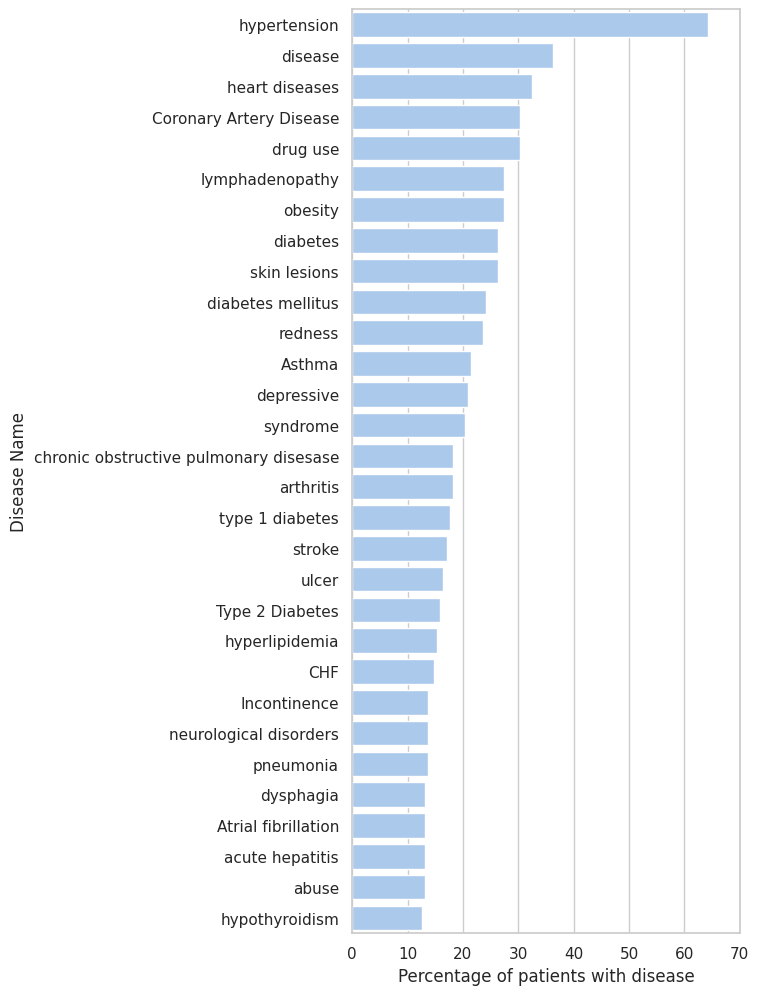

In [ ]:
# Plot the top 30 diseases
sns.reset_defaults()
sns.set(
    rc={'figure.figsize':(5,12)},
    style="whitegrid",
    palette='pastel'
)
f, ax = plt.subplots()
_data = df_cui_nsubjects.iloc[0:30]
sns.barplot(x="perc_subjects", y="name", data=_data, label="Disorder Name", color="b")
_ = ax.set(xlim=(0, 70), ylabel="Disease Name", xlabel="Percentage of patients with disease")
plt.show()

## Preparing data for supervised training (MedCATtrainer)

As we want to do some fine-tuning on the models and also some meta-annotations (e.g. Status and Temporality), we'll take the top 100 CUIs from each TUI and for each take 2 examples. We'll do this because randomly choosing documents will give us only (most likely) the concpets on the very top by frequency (especially when there is a large drop between the top concepts).

The required output format for supervised training via MedCATtrainer is CSV with `columns=(name, text)`

In [ ]:
# For each of the top 30 diseases/mental_disorders take 2 examples of documents/text
#where they appear
nexamples = 2
size = 40
loc_047_top = []
loc_048_top = []

for cui in df_cui_nsubjects[df_cui_nsubjects['tui'] == 'T047']['cui'].values[0:size]:
    loc_047_top.extend(np.array(cui_location[cui])[np.random.randint(0, len(cui_location[cui]), nexamples)])

for cui in df_cui_nsubjects[df_cui_nsubjects['tui'] == 'T048']['cui'].values[0:size]:
    loc_048_top.extend(np.array(cui_location[cui])[np.random.randint(0, len(cui_location[cui]), nexamples)])

data_047_top = data.iloc[loc_047_top]
data_048_top = data.iloc[loc_048_top]

In [ ]:
# Combine everything
train_data = pd.concat([data_047_top, data_048_top])

In [ ]:
train_data = train_data.rename(columns={'Unnamed: 0_x': "name"})
train_data = train_data[['name', 'text']]
train_data.head()

,name,text
862,1687,"SUBJECTIVE: , The patient is a 60-year-old fem..."
841,1605,"CHIEF COMPLAINT: , Chest pain and fever.,HISTO..."
241,466,"HISTORY OF PRESENT ILLNESS: , The patient is a..."
749,1383,"CHIEF COMPLAINT:, Toothache.,HISTORY OF PRESE..."
468,898,"HISTORY: , A 34-year-old male presents today s..."


In [ ]:
# Remove duplicates if we have them.
train_data = train_data.drop_duplicates(['text'])

# Save the data so that it can be imported into MedCATtrainer
train_data.to_csv(DATA_DIR + "train_data.csv", index=False)